# Projet 7   Implémentez un modèle de scoring

## Partie 2 : Features Selection

Ce notebbok traitera de la sélection des variables les plus pertinentes pour répondre au mieux au problème de classification


### Import libraries

In [43]:
# builtin
import os,warnings,sys
import time
# data
import pandas as pd
import numpy as np
from numpy.random import seed
from numpy import mean
from datetime import datetime

# visualisation
import matplotlib as mtpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
sns.color_palette("tab10", as_cmap=False)


from sklearn.dummy import DummyClassifier

# sklearn
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler,RobustScaler
from sklearn.feature_selection import VarianceThreshold,SelectKBest,f_classif,chi2,SelectFromModel
from sklearn.model_selection import (train_test_split ,learning_curve,cross_validate,
                                    GridSearchCV,cross_val_score,RepeatedStratifiedKFold)

from sklearn.metrics import( f1_score,confusion_matrix,classification_report,make_scorer,precision_score,
                            recall_score,precision_recall_fscore_support,
                            roc_auc_score, roc_curve,accuracy_score,get_scorer_names,fbeta_score,
                           )

from sklearn.tree import DecisionTreeClassifier


from feature_engine.selection import SmartCorrelatedSelection,DropConstantFeatures
from sklearn.pipeline import make_pipeline

#yellowbrick
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import ClassificationReport, DiscriminationThreshold,ROCAUC

# scipy
from scipy.stats import kstest,stats,norm,chi2_contingency

#imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE,BorderlineSMOTE, SVMSMOTE,ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.metrics import classification_report_imbalanced


plt.rcParams["figure.figsize"] = 8, 4
%matplotlib inline
sns.set_style("ticks")
sns.color_palette("tab10", as_cmap=False)
pd.set_option('display.float_format', '{:,.4f}'.format)
# pour ne pas imprimer les warnings
warnings.filterwarnings('ignore')

In [44]:
def correlation_matrice(df,corr_method):
    '''
pearson : standard correlation coefficient
kendall : Kendall Tau correlation coefficient
spearman :  Spearman rank correlation
''' 
    
    corr = df.corr(method=corr_method)
    
    mask=np.triu(np.ones_like(corr,dtype=bool))
    sns.heatmap(corr,mask=mask,center=0,cmap='RdBu',linewidths=1,annot=True,fmt='.2f',vmin=-1,vmax=1)
    plt.title('Heatmap des corrélations avec la méthode {}'.format(corr_method),fontsize=14,fontweight="bold")
    plt.show()

### loading data

In [45]:
X_train_df = pd.read_csv(r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P7\data\X_train.csv')
X_train_df.shape

(307511, 66)

In [46]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 66 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   sk_id_curr                               307511 non-null  int64  
 1   name_contract_type                       307511 non-null  object 
 2   code_gender                              307511 non-null  object 
 3   flag_own_car                             307511 non-null  object 
 4   flag_own_realty                          307511 non-null  object 
 5   name_type_suite                          307511 non-null  object 
 6   name_income_type                         307511 non-null  object 
 7   name_education_type                      307511 non-null  object 
 8   name_family_status                       307511 non-null  object 
 9   name_housing_type                        307511 non-null  object 
 10  flag_mobil                      

In [47]:
X_test = pd.read_csv(r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P7\data\X_test.csv')
X_test.shape

(48744, 65)

In [48]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 65 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   sk_id_curr                               48744 non-null  int64  
 1   name_contract_type                       48744 non-null  object 
 2   code_gender                              48744 non-null  object 
 3   flag_own_car                             48744 non-null  object 
 4   flag_own_realty                          48744 non-null  object 
 5   name_type_suite                          48744 non-null  object 
 6   name_income_type                         48744 non-null  object 
 7   name_education_type                      48744 non-null  object 
 8   name_family_status                       48744 non-null  object 
 9   name_housing_type                        48744 non-null  object 
 10  flag_mobil                               48744

### Features  object

In [49]:
liste = X_train_df.select_dtypes(include='object').columns.to_list()
print("nombre de variables:", len(liste))
print(liste)

nombre de variables: 40
['name_contract_type', 'code_gender', 'flag_own_car', 'flag_own_realty', 'name_type_suite', 'name_income_type', 'name_education_type', 'name_family_status', 'name_housing_type', 'flag_mobil', 'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email', 'region_rating_client', 'region_rating_client_w_city', 'weekday_appr_process_start', 'reg_region_not_live_region', 'reg_region_not_work_region', 'live_region_not_work_region', 'reg_city_not_live_city', 'reg_city_not_work_city', 'live_city_not_work_city', 'flag_document_3', 'flag_document_6', 'flag_document_8', 'nb_enfants', 'taux_endettement', 'nb_mensualites', 'total_revenus', 'montant_credit', 'population_region', 'age_client', 'anciennete_entreprise', 'year_registration', 'anciennete_cid', 'nb_famille', 'heure_demande_pret', 'anciennete_portable']


Parmis ces variables , il faut conserver celles qui ont un lien statistique avec la variable cible.

Pour cela on va utiliser un **test du χ2**  pour vérifier l'indépendance des 2 variables

   . H0 : les variables X et y sont indépendantes (il n'y a pas de lien entre elles )

   . H1 : les variables X et y ne sont pas indépendantes (il existe un lien entre elles)

l'hypothèse nulle est rejetée lorsque la  p-value calculée est ≤ 5%

In [50]:
# valeur cible
y = X_train_df['target']

chi_ls = []

for feature in X_train_df.select_dtypes(include='object'):
    
    # creer un tableau de contingence
    c = pd.crosstab(y, X_train_df[feature])
    
    # chi_test
    p_value = chi2_contingency(c)[1]
    chi_ls.append(p_value)

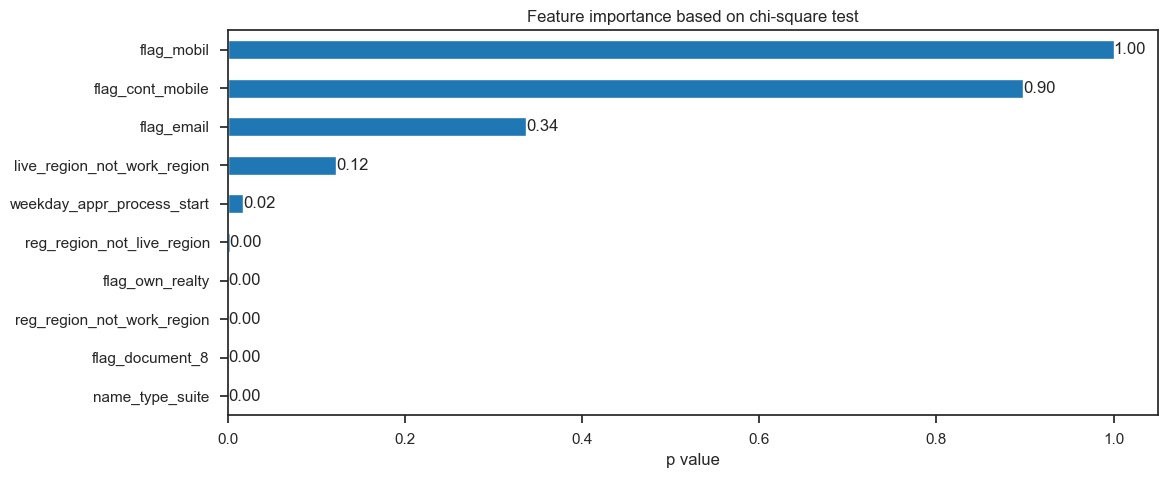

In [51]:
sns.set(style="ticks", rc={'figure.figsize': (12, 5)}, palette="tab10")

# crée un dataframe pandas
df_pvalue = pd.DataFrame(chi_ls, index=X_train_df.select_dtypes(include='object').columns, columns=['p_value']).sort_values(by='p_value', ascending=True)
# affiche les 10 derniers

ax=df_pvalue.tail(10).plot.barh()
### affichage de la valeur à côté du barplot
ax.bar_label(ax.containers[0],fmt='%.2f')
plt.xlabel('p value',loc='center')
plt.title('Feature importance based on chi-square test')
plt.legend("")
plt.show()

Le fait que le client soit en difficulté de paiement ou pas n'est pas lié au fait qu'il ait fourni
un n° de mobile (flag_mobil), 
un n° de mobile d'un contact(flag_cont_mobile),
une adresse mail(flag_email) ,
une adresse de contact différente de son adresse professionnelle(live_region_not_work_region).
De même,Le fait que le client soit en difficulté de paiement ou pas n'est pas lié au jour de la semaine où la demande de prêt précédente a été formulée (weekday_appr_process_start 
ces variables n'impactent pas sa capacité à rembourser ou pas son prêt. 
Autrement dit , au seuil de 0.01. il n'y a pas de lien entre ces variables et la variable target.
 

Nous supprimons donc ces 5 variables de nos jeux de données d'entraînement et de test.

In [52]:
var_to_drop = ['flag_mobil','flag_cont_mobile','flag_email', 'live_region_not_work_region', 'weekday_appr_process_start']

X_train_df.drop(labels=var_to_drop, axis=1, inplace=True)

X_test.drop(labels=var_to_drop, axis=1, inplace=True)

## Ordinal features

les variables catégorielles ordinales ont des modalités ordonnées.Elles peuvent être remplacées par des valeurs numériques avant leur utilisation dans les algorithmes de machine learning.


In [53]:
X_train_df# On change le type de ces variables en catégory pour X_train_df et X_test
cols_ordi = ['region_rating_client', 'region_rating_client_w_city', 'nb_enfants', 'nb_famille', 'age_client', 
                    'anciennete_entreprise', 'anciennete_cid', 'anciennete_portable', 'year_registration', 'heure_demande_pret', 
                    'population_region', 'taux_endettement', 'nb_mensualites', 'total_revenus', 'montant_credit']

X_train_df[cols_ordi] = X_train_df[cols_ordi].astype('category')
X_test[cols_ordi] = X_test[cols_ordi].astype('category')

X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 61 columns):
 #   Column                                   Non-Null Count   Dtype   
---  ------                                   --------------   -----   
 0   sk_id_curr                               307511 non-null  int64   
 1   name_contract_type                       307511 non-null  object  
 2   code_gender                              307511 non-null  object  
 3   flag_own_car                             307511 non-null  object  
 4   flag_own_realty                          307511 non-null  object  
 5   name_type_suite                          307511 non-null  object  
 6   name_income_type                         307511 non-null  object  
 7   name_education_type                      307511 non-null  object  
 8   name_family_status                       307511 non-null  object  
 9   name_housing_type                        307511 non-null  object  
 10  flag_emp_phone      

In [54]:
X_train_df# vérification ordres des modalités
for i in cols_ordi:
    X_train_df[i] = X_train_df[i].cat.as_ordered()
    X_test[i] = X_test[i].cat.as_ordered()
    print("X_train_df :",(i))
    print(X_train_df[i].head(1), end="\n\n")
    print("X_test :",(i))
    print(X_test[i].head(1), end="\n\n")

X_train_df : region_rating_client
0    note_de_2
Name: region_rating_client, dtype: category
Categories (3, object): ['note_de_1' < 'note_de_2' < 'notede_3']

X_test : region_rating_client
0    note_de_2
Name: region_rating_client, dtype: category
Categories (3, object): ['note_de_1' < 'note_de_2' < 'notede_3']

X_train_df : region_rating_client_w_city
0    note_de_2
Name: region_rating_client_w_city, dtype: category
Categories (3, object): ['note_de_1' < 'note_de_2' < 'notede_3']

X_test : region_rating_client_w_city
0    note_de_2
Name: region_rating_client_w_city, dtype: category
Categories (4, object): ['0' < 'note_de_1' < 'note_de_2' < 'notede_3']

X_train_df : nb_enfants
0    sans_enfant
Name: nb_enfants, dtype: category
Categories (4, object): ['deux_enfants' < 'sans_enfant' < 'trois_enfants_et_plus' < 'un_enfant']

X_test : nb_enfants
0    sans_enfant
Name: nb_enfants, dtype: category
Categories (4, object): ['deux_enfants' < 'sans_enfant' < 'trois_enfants_et_plus' < 'un_enfant

Les catégories bien ordonnées  peuvent être transformées directement en variables numériques

In [55]:
cols_ord = ['region_rating_client', 'region_rating_client_w_city',
                'nb_famille', 'age_client', 'taux_endettement', 
                'nb_mensualites', 'montant_credit']

# Encode labels of multiple columns at once
#
X_train_df[cols_ord] = X_train_df[cols_ord].apply(LabelEncoder().fit_transform)
X_test[cols_ord] = X_test[cols_ord].apply(LabelEncoder().fit_transform)
#
# Print head
#
X_train_df[cols_ord].head(5)


,region_rating_client,region_rating_client_w_city,nb_famille,age_client,taux_endettement,nb_mensualites,montant_credit
0,1,1,0,0,1,0,2
1,0,0,1,3,1,2,5
2,1,1,0,4,0,1,0
3,1,1,1,4,3,0,1
4,1,1,0,4,2,1,2


In [56]:
X_test[['region_rating_client', 'region_rating_client_w_city',
                'nb_famille', 'age_client', 'taux_endettement', 
                'nb_mensualites', 'montant_credit']].head(4)

,region_rating_client,region_rating_client_w_city,nb_famille,age_client,taux_endettement,nb_mensualites,montant_credit
0,1,2,1,4,2,2,3
1,1,2,1,3,2,0,0
2,1,2,1,4,4,0,3
3,1,2,3,2,2,2,5


Pour les autres,il faut indiquer l'ordre correct pour chaque modalité.

In [57]:
dif_ordi = list(set(cols_ordi).difference(set(cols_ord)))
dif_ordi

['heure_demande_pret',
 'anciennete_entreprise',
 'nb_enfants',
 'year_registration',
 'anciennete_cid',
 'population_region',
 'total_revenus',
 'anciennete_portable']

In [58]:
enf_map = {'sans_enfant': 0,
           'un_enfant': 1,
           'deux_enfants': 2,
           'trois_enfants_et_plus':3}

X_train_df['nb_enfants'] = X_train_df['nb_enfants'].map(enf_map)
X_test['nb_enfants'] = X_test['nb_enfants'].map(enf_map)

In [59]:
anc_ent_map ={'retraité_ou_sans_emploi': 0,
           '2_ans_et_moins': 1,
           '3_à_5_ans': 2,
           '6_à_9_ans': 3,
           '10_ans_et_plus': 4
           }

X_train_df['anciennete_entreprise'] = X_train_df['anciennete_entreprise'].map(anc_ent_map)
X_test['anciennete_entreprise'] = X_test['anciennete_entreprise'].map(anc_ent_map)

In [60]:
anc_cid_map = {'6_ans_et_moins': 0,
           '7_à_11_ans': 1,
           '11_et_plus': 2
           }

X_train_df['anciennete_cid'] = X_train_df['anciennete_cid'].map(anc_cid_map)
X_test['anciennete_cid'] = X_test['anciennete_cid'].map(anc_cid_map)

In [61]:
anc_gsm_map = {'23_mois_et_moins': 0,
           '24_à_63_mois': 1,
           '64_à_131_mois': 2,
           '132_mois_et_plus': 3
           }

X_train_df['anciennete_portable'] = X_train_df['anciennete_portable'].map(anc_gsm_map)
X_test['anciennete_portable'] = X_test['anciennete_portable'].map(anc_gsm_map)

In [62]:
anc_regis_map = {'6_ans_et_moins': 0,
                    '7_à_12_ans': 1,
                    '13_à_20_ans': 2,
                    '21_ans_et_plus': 3
                    }

X_train_df['year_registration'] = X_train_df['year_registration'].map(anc_regis_map)
X_test['year_registration'] = X_test['year_registration'].map(anc_regis_map)

In [63]:
X_train_df['heure_demande_pret'].unique()

['de_7h_à_12h', 'de_13h_à_18h', 'de_19h_à_6h']
Categories (3, object): ['de_13h_à_18h' < 'de_19h_à_6h' < 'de_7h_à_12h']

In [64]:
heure_pret_map = {'de_7h_à_12h': 0,
             'de_13h_à_18h': 1,
             'de_19h_à_6h': 2}

X_train_df['heure_demande_pret'] = X_train_df['heure_demande_pret'].map(heure_pret_map)
X_test['heure_demande_pret'] = X_test['heure_demande_pret'].map(heure_pret_map)

In [65]:
X_train_df
pop_reg_map = {'densité_très_faible': 0,
           'densité_faible': 1,
           'densité_moyenne': 2,
           'densité_forte': 3,
           'densité_très_forte': 4
           }

X_train_df['population_region'] = X_train_df['population_region'].map(pop_reg_map)
X_test['population_region'] = X_test['population_region'].map(pop_reg_map)

In [66]:
tot_rev_map = {'99000_et_moins': 0,
           '99001_à_135000': 1,
           '135001_à_162000': 2,
           '162001_à_225000': 3,
           '225001_et_plus': 4
           }
X_train_df['total_revenus'] = X_train_df['total_revenus'].map(tot_rev_map)
X_test['total_revenus'] = X_test['total_revenus'].map(tot_rev_map)           
           

In [67]:
def cat_analyzer(dataframe, variable):
    print(variable)
    print(pd.DataFrame({
            "COUNT": dataframe[variable].value_counts(),
            "RATIO": dataframe[variable].value_counts() / len(dataframe) *100}), end="\n\n\n")
    

for i in cols_ordi:
    cat_analyzer(X_train_df, i)

region_rating_client
    COUNT   RATIO
1  226984 73.8133
2   48330 15.7165
0   32197 10.4702


region_rating_client_w_city
    COUNT   RATIO
1  229484 74.6263
2   43860 14.2629
0   34167 11.1108


nb_enfants
    COUNT   RATIO
0  215371 70.0368
1   61119 19.8754
2   26749  8.6986
3    4272  1.3892


nb_famille
    COUNT   RATIO
1  158359 51.4970
0   67847 22.0633
2   52601 17.1054
3   24697  8.0313
4    3478  1.1310
5     529  0.1720


age_client
   COUNT   RATIO
0  56890 18.5002
4  54864 17.8413
2  51486 16.7428
3  50441 16.4030
1  48331 15.7168
5  45499 14.7959


anciennete_entreprise
    COUNT   RATIO
1  130452 42.4219
2   69845 22.7130
4   55410 18.0189
3   51804 16.8462


anciennete_cid
    COUNT   RATIO
1  110236 35.8478
0  108049 35.1366
2   89226 29.0155


anciennete_portable
   COUNT   RATIO
0  78127 25.4062
2  77187 25.1006
1  76196 24.7783
3  76001 24.7149


year_registration
   COUNT   RATIO
0  87086 28.3196
3  76814 24.9793
2  74845 24.3390
1  68766 22.3621


heure_demande_

In [68]:
var_cat = X_train_df.select_dtypes(include='category').columns.to_list()

X_train_df[var_cat] = X_train_df[var_cat].astype('int8')
X_test[var_cat] = X_test[var_cat].astype('int8')

## Nominal features

Les variables categorielles nominales sont constituées de valeurs discrètes qui n'ont pas de relation numérique entre les différentes catégories

In [69]:
cols_nomi = X_train_df.select_dtypes(include='object').columns.to_list()
print(cols_nomi)

['name_contract_type', 'code_gender', 'flag_own_car', 'flag_own_realty', 'name_type_suite', 'name_income_type', 'name_education_type', 'name_family_status', 'name_housing_type', 'flag_emp_phone', 'flag_work_phone', 'flag_phone', 'reg_region_not_live_region', 'reg_region_not_work_region', 'reg_city_not_live_city', 'reg_city_not_work_city', 'live_city_not_work_city', 'flag_document_3', 'flag_document_6', 'flag_document_8']


In [70]:
X_train_df = pd.get_dummies(X_train_df,
                         columns=cols_nomi,
                         drop_first=True)


In [71]:
X_test = pd.get_dummies(X_test,
                         columns=cols_nomi,
                         drop_first=True)


In [72]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 64 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   sk_id_curr                                    307511 non-null  int64  
 1   region_rating_client                          307511 non-null  int32  
 2   region_rating_client_w_city                   307511 non-null  int32  
 3   ext_source_2                                  307511 non-null  float64
 4   nb_enfants                                    307511 non-null  int8   
 5   taux_endettement                              307511 non-null  int32  
 6   nb_mensualites                                307511 non-null  int32  
 7   total_revenus                                 307511 non-null  int8   
 8   montant_credit                                307511 non-null  int32  
 9   target                                        30

In [73]:
X_train_df.shape,X_test.shape

((307511, 64), (48744, 63))

In [74]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 64 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   sk_id_curr                                    307511 non-null  int64  
 1   region_rating_client                          307511 non-null  int32  
 2   region_rating_client_w_city                   307511 non-null  int32  
 3   ext_source_2                                  307511 non-null  float64
 4   nb_enfants                                    307511 non-null  int8   
 5   taux_endettement                              307511 non-null  int32  
 6   nb_mensualites                                307511 non-null  int32  
 7   total_revenus                                 307511 non-null  int8   
 8   montant_credit                                307511 non-null  int32  
 9   target                                        30

### features

On va rechercher les variables qui ont une variance faible ou nulle , les variables corrélées et les doublons afin de réduire le nombre de caractéristiques peu pertinentes pour notre modélisation.

### Low variance features

In [75]:
#Variables qui ont la même valeur dans plus de 98% des observations 
#seront considérées comme constant /quasi-constant et seront supprimées

drop_constant=DropConstantFeatures(variables=None,tol=0.98)
drop_constant.fit(X_train_df) 

DropConstantFeatures(tol=0.98)

In [76]:
list_const=drop_constant.features_to_drop_

In [77]:
sum(drop_constant.get_support())

62

In [78]:
# on supprime les 2 variables quasi-constante à plus de 98%

X_train_df=drop_constant.fit_transform(X_train_df) 
X_test.drop(labels=list_const,inplace=True,axis=1)

In [79]:
X_train_df.shape

(307511, 62)

In [80]:
X_test.shape

(48744, 61)

In [81]:
 #Mettre un seuil de variance =0 revient à chercher les caractéristiques qui ont une valeur constante
y=X_train_df['target']
X_train_df.drop(columns='target',inplace=True,axis=1)
thres= VarianceThreshold(threshold=X_train_df.var(axis=0).median())

thres.fit(X_train_df)  #

VarianceThreshold(threshold=0.49999864004528577)

In [82]:
sum(thres.get_support())

30

In [83]:
concol = [column for column in X_train_df.columns 
          if column not in X_train_df.columns[thres.get_support()]]

for features in concol:
    print(features)
print('nombre de colonnes:',len(concol))

region_rating_client
region_rating_client_w_city
ext_source_2
nb_enfants
heure_demande_pret
prev_contrat_statut_unused offer
days_past_due
days_before_due
bureau_credit_type_other_credit
name_contract_type_Revolving loans
code_gender_Homme
flag_own_car_Y
flag_own_realty_Y
name_type_suite_Famille
name_type_suite_Non_accompagné
name_income_type_fonctionnaire
name_income_type_homme_d_affaire
name_income_type_sans_emploi
name_education_type_enseignement_superieur
name_family_status_seul
name_housing_type_maison_ou_appartement
flag_emp_phone_Oui
flag_work_phone_Oui
flag_phone_Oui
reg_region_not_work_region_adresse identique
reg_city_not_live_city_adresse identique
reg_city_not_work_city_adresse identique
live_city_not_work_city_adresse identique
flag_document_3_Oui
flag_document_6_Oui
flag_document_8_Oui
nombre de colonnes: 31


In [84]:
X_train_df.shape

(307511, 61)

In [85]:
#X_train_df=X_train_df.drop(concol,axis=1)

In [86]:
X_train_df.shape

(307511, 61)

In [87]:
#X_test=X_test.drop(concol,axis=1)

### correlation

On regarde si il y a des valeurs  fortement corrélées (threshold = 0.8)

In [88]:
# on peut utiliser smartCorrelatedSelection

smart_correl = SmartCorrelatedSelection(
    variables=None,
    method="spearman",
    threshold=0.8,
    missing_values="raise",
    selection_method="variance",
    estimator=None,
    scoring="roc_auc",
    cv=3,
)

smart_correl.fit(X_train_df, y)

SmartCorrelatedSelection(method='spearman', missing_values='raise',
                         selection_method='variance')

In [89]:
# # afficher le groupe de variables et les valeurs corrélées 
for group in range(len(smart_correl.correlated_feature_sets_)):
    print(smart_correl.correlated_feature_sets_[group])
    print('-----------------------------------------------------------------------------------------')
    print(X_train_df[smart_correl.correlated_feature_sets_[group]].std())
    print('   ')

{'region_rating_client', 'region_rating_client_w_city'}
-----------------------------------------------------------------------------------------
region_rating_client          0.5090
region_rating_client_w_city   0.5027
dtype: float64
   
{'nb_enfants', 'nb_famille'}
-----------------------------------------------------------------------------------------
nb_enfants   0.7071
nb_famille   0.9051
dtype: float64
   
{'name_type_suite_Famille', 'name_type_suite_Non_accompagné'}
-----------------------------------------------------------------------------------------
name_type_suite_Famille          0.3826
name_type_suite_Non_accompagné   0.3904
dtype: float64
   
{'flag_emp_phone_Oui', 'name_income_type_sans_emploi'}
-----------------------------------------------------------------------------------------
flag_emp_phone_Oui             0.3843
name_income_type_sans_emploi   0.3843
dtype: float64
   
{'live_city_not_work_city_adresse identique', 'reg_city_not_work_city_adresse identique'}
--

In [90]:
#  donne la variable avec plus haute valeur de chaque groupe

list_smart=smart_correl.features_to_drop_
list_smart

['region_rating_client_w_city',
 'nb_enfants',
 'name_type_suite_Famille',
 'flag_emp_phone_Oui',
 'live_city_not_work_city_adresse identique']

In [91]:
# supprimer les variables hautement corrélées
X_train_df = smart_correl.transform(X_train_df)
X_test .drop(labels=list_smart,inplace=True,axis=1)

X_train_df.shape, X_test.shape

((307511, 56), (48744, 56))

In [92]:
X_train_df

,sk_id_curr,region_rating_client,ext_source_2,taux_endettement,nb_mensualites,total_revenus,montant_credit,population_region,age_client,anciennete_entreprise,...,name_family_status_seul,name_housing_type_maison_ou_appartement,flag_work_phone_Oui,flag_phone_Oui,reg_region_not_work_region_adresse identique,reg_city_not_live_city_adresse identique,reg_city_not_work_city_adresse identique,flag_document_3_Oui,flag_document_6_Oui,flag_document_8_Oui
0,100002,1,0.2629,1,0,3,2,2,0,1,...,1,1,0,1,1,1,1,1,0,0
1,100003,0,0.6222,1,2,4,5,0,3,2,...,0,1,0,1,1,1,1,1,0,0
2,100004,1,0.5559,0,1,0,0,1,4,1,...,1,1,1,1,1,1,1,0,0,0
3,100006,1,0.6504,3,0,1,1,0,4,3,...,0,1,0,0,1,1,1,1,0,0
4,100007,1,0.3227,2,1,1,2,3,4,3,...,1,1,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0.6816,2,0,2,1,4,0,1,...,1,0,0,0,1,1,1,0,0,1
307507,456252,1,0.1160,2,1,0,1,3,4,1,...,1,1,0,1,1,1,1,1,0,0
307508,456253,2,0.5357,3,1,2,3,0,2,4,...,1,1,0,0,1,1,0,1,0,0
307509,456254,1,0.5142,1,0,3,2,0,1,4,...,0,1,0,0,1,0,0,1,0,0


In [93]:
X_train_df.info()
X_train_df['target']=y

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 56 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   sk_id_curr                                    307511 non-null  int64  
 1   region_rating_client                          307511 non-null  int32  
 2   ext_source_2                                  307511 non-null  float64
 3   taux_endettement                              307511 non-null  int32  
 4   nb_mensualites                                307511 non-null  int32  
 5   total_revenus                                 307511 non-null  int8   
 6   montant_credit                                307511 non-null  int32  
 7   population_region                             307511 non-null  int8   
 8   age_client                                    307511 non-null  int32  
 9   anciennete_entreprise                         30

## Target : Client en difficulté de paiement ?

Cible :  prédire si le client est fiable c-à- n'a pas de difficulté de paiement et peut donc recevoir un crédit à la consommation de la société "Prêt à dépenser"  

<Figure size 800x400 with 0 Axes>

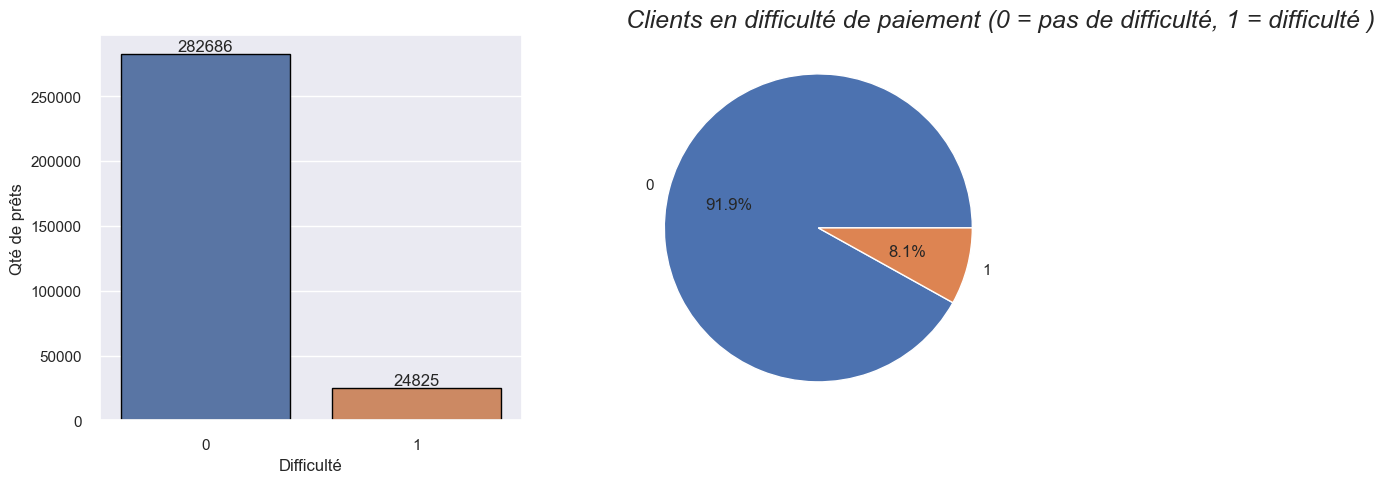

In [94]:
fig = plt.figure(figsize=(8, 4))
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (1 rows, 2 columns)
fig, ax = plt.subplots(1, 2)


sns.countplot(data=X_train_df, x="target", edgecolor="black",ax=ax[0])
       
plt.title("Clients en difficulté de paiement (0 = pas de difficulté, 1 = difficulté ) ",loc='left', fontsize=18, fontstyle='italic')
ax[0].set_xlabel('Difficulté')
ax[0].set_ylabel('Qté de prêts')
for label in ax[0].containers:
    ax[0].bar_label(label)

type_count = X_train_df['target'].value_counts().reset_index()
ax1=plt.pie(labels=type_count['index'], x=type_count['target'], autopct='%.1f%%')
plt.show()


Il y a 8,1 % de clients en difficulté de paiement contre 91.9% sans difficulté.
En  ML, cette différence importante de classes peut nuire à la fiabilité des prédictions . 

 **1. solution de résolution au niveau des données.**

On peut ré-équilibrer les classes en augmentant artificiellement le nombre de données dans la classe minoritaire (upsampling ou sur-échantillonnage) ou en réduisant dans la classe majoritaire ( downsampling ou sous-échantillonnage)

en downsampling  

 On peut retirer aléatoirement des points de la classe majoritaire pour réduire le déséquilibre.    
 Une autre possibilité est de créer des paires de points appelées **Tomek link**  constituées d'un point de la classe majoritaire proche d'un point de la classe minoritaire et d'éliminer le point de la classe majoritaire. Cette technique permet en outre de supprimer les  outliers et de réduire la variance de la classe majoritaire.

en upsampling :

on va créer de nouveaux points à partir de points existants de la classe minoritaire (similaire à la DATA AUGMENTATION utilisée pour réduire l'overfitting).On sélectionne des points de la classe minoritaire. Pour chacun des points on recherche les k plus proches voisins et on crée un point synthétique appartenant à la classe minoritaire.  
**SMOTE**  : Synthetic Minority Oversampling Technic ou suréchantillonnage minoritaire synthétique  
**ADASYN** : ADAptive SYNthetic sampling ou échantillonnage synthétique adaptatif.Ici le nombre d' échantillons synthétiques généré est proportionnel au nombre d'échantillons sélectionnés qui ne sont pas de la classe minoritaire. En conséquence , l'algorithme va générés plus d'exemples synthétiques dans les zones où les échantillons  de la classe minoritaire sont rares.

 **2. solution de résolution au niveau des algorithmes.**
 
 On affecte un poids plus important à la classe minoritaire.( apprentissage sensible aux coûts)
 En pratique, on va spécifier à notre modèle que le fait de bien classer un point de la classe minoritaire est plus important que de bien classer un point de la classe majoritaire. De cette façon on s’arrange pour qu’une erreur de classification d’un point de la classe minoritaire soit considérée par le modèle comme étant plus grave qu’une erreur de classification sur la classe majoritaire. L'objectif des modèles de machine learning étant de toujours d’optimiser un paramètre prédéfini, l’optimisation du gain va inciter l’algorithme à donner plus d’importance à la classe minoritaire et donc à améliorer les prédictions sur celle-ci.
 
 Apprentissage à une classe :

Plutôt que d’entraîner un classifieur sur nos 2 classes, on entraîne un détecteur sur la classe majoritaire. Il sera ensuite capable de prédire si un point fait partie de la classe ou non. Même si les modèles d’apprentissage à une classe ne sont pas spécialement conçus pour contrer le déséquilibre des classes, ils peuvent offrir de gros gains de performances.Cette approche peut donner de bons résultats dans certains cas.





# Pre-Processing

In [95]:
# sauvegarde du X_train non normalisé et non splitté +  contenant sk_id_curr 
# sauvegarde du X_test contenant sk_id_curr 
X_train_df.to_csv(r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P7\data\preproc\X_train_raw.csv',index=False)
X_test.to_csv(r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P7\data\preproc\X_test_raw.csv',index=False)

In [96]:
X_train_df.drop(labels='sk_id_curr', axis=1, inplace=True)
X_test.drop(labels='sk_id_curr', axis=1, inplace=True)

## Training , Validation  and Test set

Le set de test existe déjà : X_test  
Il faut maintenant créer un set de validation X_val à partir du set X_train existant. 30% des données seront utilisées dans le X_val . Les 70 % restantes constitueront le X_train.


In [97]:
# X_train_df est séparé en X_train_df (70%) et X_val_df (30%)
X_train_df,X_val_df=train_test_split(X_train_df,test_size=0.3,random_state=1234)


In [98]:
y_train=X_train_df['target']
y_val=X_val_df['target']

X_train_df.drop(labels='target', axis=1, inplace=True)
X_val_df.drop(labels='target', axis=1, inplace=True)

In [99]:
print("y_train - target")
print(pd.DataFrame({
    "COUNT": y_train.value_counts(),
    "RATIO": y_train.value_counts() / len(y_train) * 100}))

y_train - target
    COUNT   RATIO
0  197870 91.9227
1   17387  8.0773


In [100]:
print("y_val - target")
print(pd.DataFrame({
    "COUNT": y_val.value_counts(),
    "RATIO": y_val.value_counts() / len(y_val) * 100}))

y_val - target
   COUNT   RATIO
0  84816 91.9375
1   7438  8.0625


## StandardScaler

In [101]:
# Normalisation des données
scaler = StandardScaler()
scaler.fit(X_train_df)
scaler.fit(X_val_df)

X_train = scaler.transform(X_train_df)
X_val = scaler.transform(X_val_df)

##  Metrics

**choix des métriques de mesure des performances des modèles**
Avec des données déséquilibrées, il faut opter pour des métriques qui sont moins influencées par la classe majoritaire tels que le recall et le F-score.Si on ne le fait pas ,on peut penser que le modèle donne de bons résultats parce que le score est élevé alors que les prédictions ne sont correctes que pour la classe majoritaire et qu'une grande partie des points de la classe minoritaire sont mal classifiés. Le score est affecté par le déséquilibre des classes.
De plus dans notre cas, une erreur de prédiction est plus dommageable que l'autre.

**Les faux positifs sont de bons clients marqués comme mauvais.Le prêt ne leur est pas accordé.
       --> la banque perd le client ( erreur de type 1 )
       
**Les faux négatifs sont de mauvais clients marqués comme bons . Le prêt leur est accordé.
       --> cela représente une Perte financière pour la société de crédit (erreur de type 2)

la **mesure Fbeta** calcule une moyenne harmonique pondérée de précision et de rappel tout en privilégiant les scores de rappel supérieurs aux scores de précision.Le modèle minimise les erreurs de classification pour la classe positive tout en privilégiant les modèles qui minimisent les faux négatifs plutôt que les faux positifs.


La **précision** est le nombre de résultats positifs corrects divisé par le nombre de tous les résultats positifs 

Le **rappel(recall** est le nombre de résultats positifs corrects divisé par le nombre de résultats positifs qui auraient dû être renvoyés .

Le **score F1** est une mesure de la précision d'un test. Il prend en compte à la fois la précision et le rappel du test pour calculer le score. Le score F1 peut être interprété comme une moyenne pondérée de la précision et du rappel, où un score F1 atteint sa meilleure valeur à 1 et la pire à 0.

L'**accuracy** décrit la performance du modèle sur les individus positifs et négatifs de façon symétrique. Elle mesure le taux de prédictions correctes sur l’ensemble des individus :
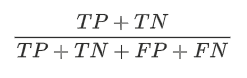
**precision** = true positives / (true positives + false positives)

**recall** = true positives / (false negatives + true positives)

**F1 score** = 2 * ((precision * recall) / (precision + recall))


## Evaluation

In [103]:
#Choix d'un arbre de décision 

model1=DecisionTreeClassifier(random_state=1234)


In [104]:
def evaluation(model):
    model.fit(X_train,y_train)
    ypred=model.predict(X_val)
    
    print(confusion_matrix(y_val,ypred))
    print(classification_report(y_val,ypred))
    
    #learning_curve
    N,train_score,val_score=learning_curve(model,X_train,y_train,cv=3,scoring='f1',train_sizes=np.linspace(0.1,1,5))
    
    #affichage
    plt.figure(figsize=(4,4))
    plt.plot(N,train_score.mean(axis=1),label="train score")
    plt.plot(N,val_score.mean(axis=1),label="validation score")
    plt.legend()
    plt.show()

[[77138  7678]
 [ 6255  1183]]
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     84816
           1       0.13      0.16      0.15      7438

    accuracy                           0.85     92254
   macro avg       0.53      0.53      0.53     92254
weighted avg       0.86      0.85      0.85     92254



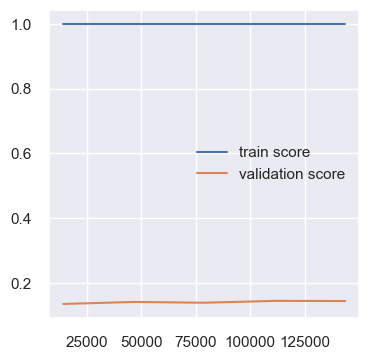

In [61]:
evaluation(model1)

Explications des valeurs du tableau:
    
    sur la modalité 1 : le modele a detecté  1183 vrais négatifs mais a rejeté 6255 faux negatifs
    c-à-d qu'il a bien classifié 1183 clients "mauvais payeur" mais  qu'il en a classifié 6255 comme étant des clients "bon payeur" (erreur de type 2 qui est beaucoup plus grave pour la banque en terme de perte financière)
    
    sur la modalité 0 : le modele a bien classifié 77138 clients "bon payeur" et en a classifié 7678 comme étant des clients "mauvais payeur " (erreur de type 1)
        

## Classification report 

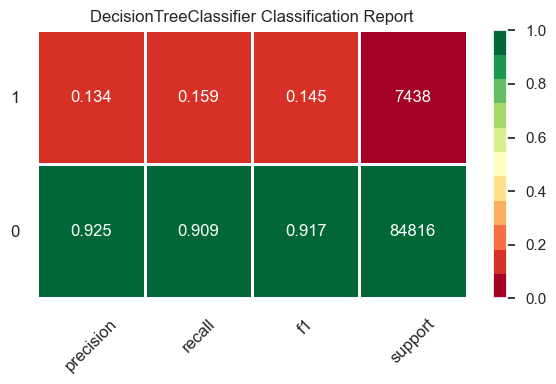

<Axes: title={'center': 'DecisionTreeClassifier Classification Report'}>

In [62]:
fig, ax = plt.subplots(figsize=(6, 4))

visualizer = ClassificationReport(model1, support=True, cmap='RdYlGn')

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_val, y_val)        # Evaluate the model on the test data
visualizer.show()    

##  ROC-AUC

La courbe ROC (Receiver Operating Charasteristic) et l’AUC (Area Under Curve, soit l’aire sous la courbe) sont deux indicateurs permettant d’analyser un modèle et en particulier son seuil de détection.

La courbe ROC (ou courbe des caractéristiques de fonctionnement du récepteur ) est une mesure graphique  pour évaluer les performances ou la précision d’un classificateur, qui correspond à la proportion totale d’observations correctement classées.

Deux indicateurs sont utilisés pour tracer la courbe ROC :

Le taux de vrais positifs (TVP) : Le taux de vrais positifs correspond à la proportion de vrais positifs sur l’ensemble des données positives. Il s’agit donc d’un autre nom du rappel ou de la sensibilité.

Le taux de faux positifs (TFP) : Le taux de faux positifs correspond à la proportion de faux positifs sur l’ensemble des négatifs. Il se calcule  comme étant 1 - spécificité.

Les courbes ROC présentent généralement un taux de vrais positifs sur l'axe Y et un taux de faux positifs sur l'axe X. 

La «pente» des courbes ROC est également importante, car elle est idéale pour maximiser le taux de vrais positifs tout en minimisant le taux de faux positifs.

L’ aire sous la courbe ( AUC ) résume la performance globale du classificateur.La métrique AUC varie entre 0,50 (classificateur aléatoire) et 1,00. Les valeurs supérieures à 0,80 sont une indication d’un bon classificateur.

Grâce à cette courbe, il devient facile de comparer deux modèles pour déterminer le meilleur : celui qui a sa courbe ROC bien au-dessus de l’autre. Dans le cas où les courbes se croisent, tout dépendra des erreurs les moins graves et des seuils choisis, mais c’est le point le plus proche de (0,1) qui sera le plus intéressant (soit le coin en haut à gauche).



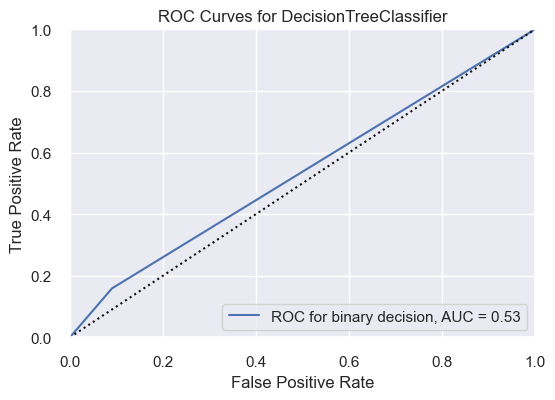

<Axes: title={'center': 'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [63]:
fig, ax = plt.subplots(figsize=(6, 4))

visualizer = ROCAUC(model1, binary=True, 
                    random_state=1234)

visualizer.fit(X_train, y_train)        
visualizer.score(X_val, y_val)
visualizer.show()            

## Classes Balance methods

### transformers RandomOverSampler et RandomUnderSampler from imblearn

In [105]:
# Sur-échantillonnage
rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)
print("y_sm -Oversampling target")
print(pd.DataFrame({
    "COUNT": y_ro.value_counts(),
    "RATIO": y_ro.value_counts() / len(y_ro) * 100}))
print('-----------------------------------------------')
# Entraînement du modèle d'arbre
model1 = DecisionTreeClassifier(random_state=1234)
rd_over_=model1.fit(X_ro, y_ro)
# Affichage des résultats
y_pred = rd_over_.predict(X_val)
print(classification_report_imbalanced(y_val, y_pred))

# Sous-échantillonnage
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)

print("y_ru -Undersampling target")
print(pd.DataFrame({
    "COUNT": y_ru.value_counts(),
    "RATIO": y_ru.value_counts() / len(y_ru) * 100}))
print('-----------------------------------------------')
# Entraînement du modèle d'arbre
rd_under_=model1.fit(X_ru, y_ru)
# Affichage des résultats
y_pred = rd_under_.predict(X_val)
print(classification_report_imbalanced(y_val, y_pred))


y_sm -Oversampling target
    COUNT   RATIO
0  197870 50.0000
1  197870 50.0000
-----------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.92      0.14      0.92      0.35      0.14     84816
          1       0.13      0.14      0.92      0.13      0.35      0.12      7438

avg / total       0.86      0.86      0.20      0.86      0.35      0.13     92254

y_ru -Undersampling target
   COUNT   RATIO
0  17387 50.0000
1  17387 50.0000
-----------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.57      0.58      0.71      0.57      0.33     84816
          1       0.11      0.58      0.57      0.18      0.57      0.33      7438

avg / total       0.87      0.57      0.58      0.67      0.57      0.33     92254



RandomUnderSampler donne un f1-score=0.18

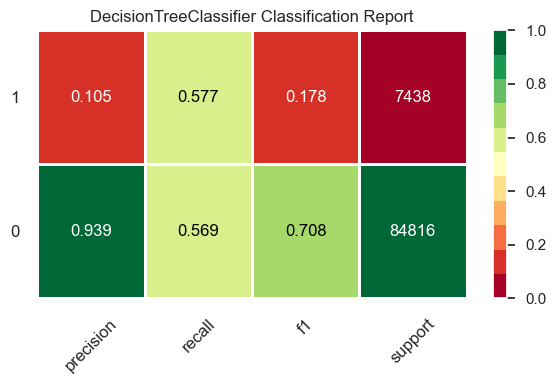

<Axes: title={'center': 'DecisionTreeClassifier Classification Report'}>

In [108]:
fig, ax = plt.subplots(figsize=(6, 4))

visualizer = ClassificationReport(rd_over_, support=True, cmap='RdYlGn')

visualizer.fit(X_ro, y_ro)        # Fit the visualizer and the model
visualizer.score(X_val, y_val)        # Evaluate the model on the val data
visualizer.show()    

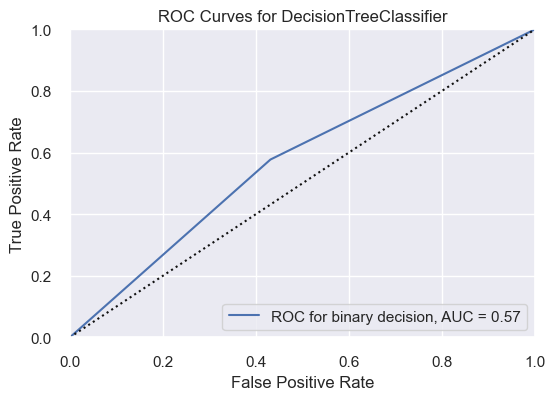

<Axes: title={'center': 'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [109]:
fig, ax = plt.subplots(figsize=(6, 4))

visualizer = ROCAUC(rd_over_, binary=True, 
                    random_state=1234)

visualizer.fit(X_ro, y_ro)         
visualizer.score(X_val, y_val)
visualizer.show() 

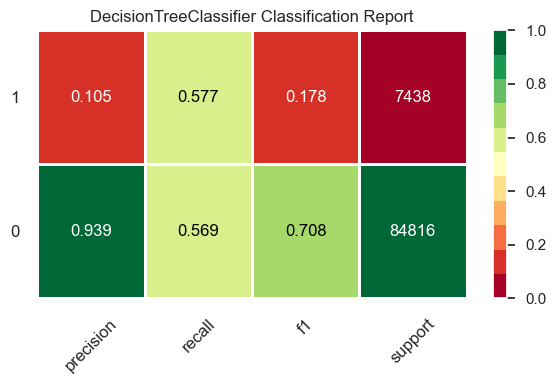

<Axes: title={'center': 'DecisionTreeClassifier Classification Report'}>

In [107]:
fig, ax = plt.subplots(figsize=(6, 4))

visualizer = ClassificationReport(rd_under_, support=True, cmap='RdYlGn')

visualizer.fit(X_ru, y_ru)        # Fit the visualizer and the model
visualizer.score(X_val, y_val)        # Evaluate the model on the val data
visualizer.show()    

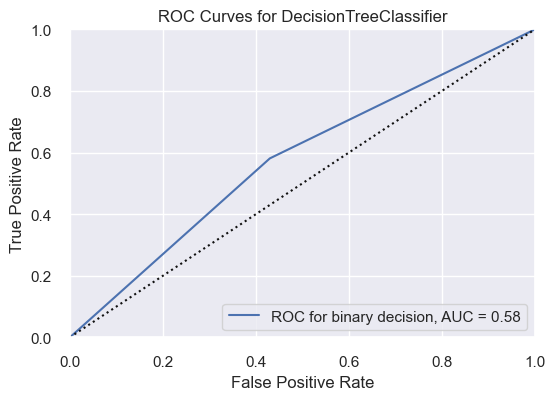

<Axes: title={'center': 'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [66]:
fig, ax = plt.subplots(figsize=(6, 4))

visualizer = ROCAUC(rd_under_, binary=True, 
                    random_state=1234)

visualizer.fit(X_ru, y_ru)         
visualizer.score(X_val, y_val)
visualizer.show() 

###  SMOTE  

In [67]:
# SMOTE La génération d’échantillons synthétiques
smo = SMOTE()
X_sm, y_sm = smo.fit_resample(X_train, y_train)
print("y_sm -Resampling SMOTE")
print(pd.DataFrame({
    "COUNT": y_sm.value_counts(),
    "RATIO": y_sm.value_counts() / len(y_sm) * 100}))
print('-----------------------------------------------')
# Entraînement du modèle d'arbre
sm_over_=model1.fit(X_sm, y_sm)
# Affichage des résultats
y_pred = sm_over_.predict(X_val)
print(classification_report_imbalanced(y_val, y_pred))

y_sm -Resampling SMOTE
    COUNT   RATIO
0  197870 50.0000
1  197870 50.0000
-----------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.90      0.17      0.91      0.39      0.17     84816
          1       0.13      0.17      0.90      0.15      0.39      0.14      7438

avg / total       0.86      0.84      0.23      0.85      0.39      0.16     92254



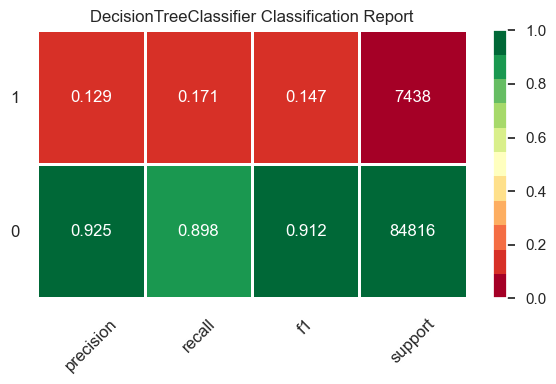

<Axes: title={'center': 'DecisionTreeClassifier Classification Report'}>

In [68]:
fig, ax = plt.subplots(figsize=(6, 4))

visualizer = ClassificationReport(sm_over_, support=True, cmap='RdYlGn')

visualizer.fit(X_sm, y_sm)        # Fit the visualizer and the model
visualizer.score(X_val, y_val)        # Evaluate the model on the val data
visualizer.show()

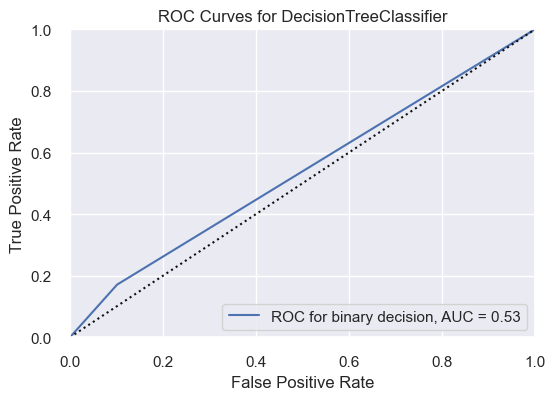

<Axes: title={'center': 'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [69]:
fig, ax = plt.subplots(figsize=(6, 4))

visualizer = ROCAUC(sm_over_, binary=True, 
                    random_state=1234)

visualizer.fit(X_sm, y_sm)         
visualizer.score(X_val, y_val)
visualizer.show() 

### Transformer SMOTE avec RepeatedStratifieldKFold 3 x10 splits

In [70]:
# decision tree evaluated on imbalanced dataset with SMOTE oversampling
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# define pipeline
steps = [('over', SMOTE()), ('model', model1)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1234)
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))


Mean ROC AUC: 0.534


### Transformer SMOTE sur la classe minoritaire avec un sous-échantillonnage aléatoire de la classe majoritaire avec RepeatedStratifieldKFold 3 x10 splits 
 
 

In [71]:
# define pipeline

over = SMOTE(sampling_strategy=0.2)  #  augmente la classe minoritaire de 5 x sa taille initiale
under = RandomUnderSampler(sampling_strategy=0.5,random_state=1234)  # réduit la classe majoritaire de moitié
steps = [('over', over), ('under', under), ('model', model1)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1234)
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.556


In [72]:
# idemm avec knn et différentes valeurs de k
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
 # define pipeline
 model = DecisionTreeClassifier()
 over = SMOTE(sampling_strategy=0.2, k_neighbors=k)#  augmente la classe minoritaire de 5 x sa taille initiale
 under = RandomUnderSampler(sampling_strategy=0.5)# réduit la classe majoritaire de moitié
 steps = [('over', over), ('under', under), ('model', model)]
 pipeline = Pipeline(steps=steps)
 # evaluate pipeline
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
 score = mean(scores)
 print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.554
> k=2, Mean ROC AUC: 0.552
> k=3, Mean ROC AUC: 0.553
> k=4, Mean ROC AUC: 0.554
> k=5, Mean ROC AUC: 0.555
> k=6, Mean ROC AUC: 0.555
> k=7, Mean ROC AUC: 0.555


###  Transformer BorderlineSMOTE

extension de SMOTE plus sélective dans le choix des échantillons de la classe minoritaire qui sont utilisés pour générer les nouveaux échantillons synthétiques.

Au lieu de générer aveuglément de nouveaux exemples synthétiques pour la classe minoritaire, la méthode Borderline-SMOTE va générer des échantillons synthétiques uniquement le long de la frontière de décision entre les deux classes.

In [73]:
from imblearn.over_sampling import BorderlineSMOTE
from matplotlib import pyplot
from numpy import where

# transform the dataset
border_sm = BorderlineSMOTE()
X_bsm, y_bsm = border_sm.fit_resample(X_train, y_train)

print("y_bsm -Resampling BorderlineSmote")
print(pd.DataFrame({
    "COUNT": y_bsm.value_counts(),
    "RATIO": y_bsm.value_counts() / len(y_bsm) * 100}))
print('-----------------------------------------------')
# Entraînement du modèle d'arbre
bsm_over_=model1.fit(X_bsm, y_bsm)
# Affichage des résultats
y_pred = bsm_over_.predict(X_val)
print(classification_report_imbalanced(y_val, y_pred))


y_bsm -Resampling BorderlineSmote
    COUNT   RATIO
0  197870 50.0000
1  197870 50.0000
-----------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.90      0.17      0.91      0.39      0.16     84816
          1       0.13      0.17      0.90      0.15      0.39      0.14      7438

avg / total       0.86      0.84      0.23      0.85      0.39      0.16     92254



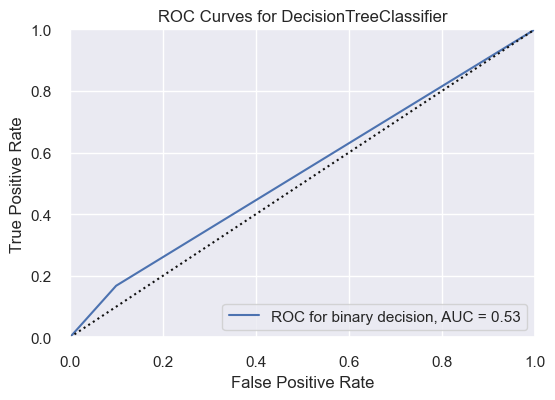

<Axes: title={'center': 'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [74]:
fig, ax = plt.subplots(figsize=(6, 4))

visualizer = ROCAUC(bsm_over_, binary=True, 
                    random_state=1234)

visualizer.fit(X_bsm, y_bsm)         
visualizer.score(X_val, y_val)
visualizer.show() 

### Transformer borderline SVMSMOTE 

La zone limite est approximée par les vecteurs de support obtenus après entraînement d'un classificateur SVM standard sur l'ensemble d'entraînement d'origine.

In [105]:
# transform the dataset
svmsm = SVMSMOTE()
X_svmsm, y_svmsm = svmsm.fit_resample(X_train, y_train)

print("y_svmsm -Resampling SVMSMOTE")
print(pd.DataFrame({
    "COUNT": y_svmsm.value_counts(),
    "RATIO": y_svmsm.value_counts() / len(y_svmsm) * 100}))
print('-----------------------------------------------')
# Entraînement du modèle d'arbre
bsm_svm_=model1.fit(X_svmsm, y_svmsm)
# Affichage des résultats
y_pred = bsm_svm_.predict(X_val)
print(classification_report_imbalanced(y_val, y_pred))

y_svmsm -Resampling SVMSMOTE
    COUNT   RATIO
0  197870 50.0000
1  197870 50.0000
-----------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.90      0.19      0.91      0.41      0.18     84816
          1       0.14      0.19      0.90      0.16      0.41      0.16      7438

avg / total       0.86      0.84      0.25      0.85      0.41      0.18     92254



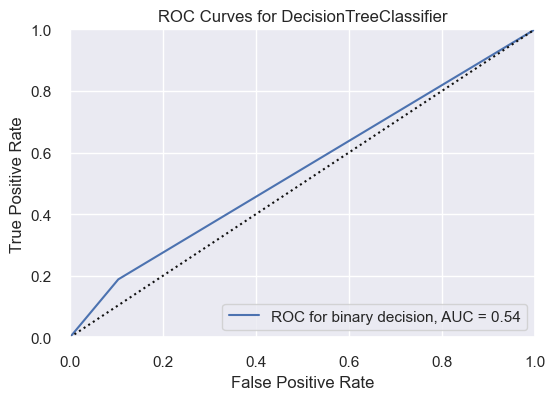

<Axes: title={'center': 'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [106]:
fig, ax = plt.subplots(figsize=(6, 4))

visualizer = ROCAUC(bsm_svm_, binary=True, 
                    random_state=1234)

visualizer.fit(X_svmsm, y_svmsm)         
visualizer.score(X_val, y_val)
visualizer.show() 

### Adaptive Synthetic Sampling (ADASYN)

 ADASYN génére des échantillons synthétiques inversement proportionnels à la densité des échantillons dans la classe minoritaire.
Autrement dit, ce transformer génére plus d'échantillons synthétiques dans les régions de l'espace des caractéristiques où la densité d'échantillons minoritaires est faible, et peu ou pas d'échantillons là où la densité est élevée.

In [108]:

ada = ADASYN()
X_ada, y_ada = ada.fit_resample(X_train, y_train)
print("y_ada -Resampling ADASYN")
print(pd.DataFrame({
    "COUNT": y_ada.value_counts(),
    "RATIO": y_ada.value_counts() / len(y_ada) * 100}))
print('-----------------------------------------------')
# Entraînement du modèle d'arbre
ada_=model1.fit(X_ada, y_ada)
# Affichage des résultats
y_pred = ada_.predict(X_val)
print(classification_report_imbalanced(y_val, y_pred))



y_ada -Resampling ADASYN
    COUNT   RATIO
0  197870 50.0311
1  197624 49.9689
-----------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.90      0.17      0.91      0.39      0.16     84816
          1       0.13      0.17      0.90      0.15      0.39      0.14      7438

avg / total       0.86      0.84      0.23      0.85      0.39      0.16     92254



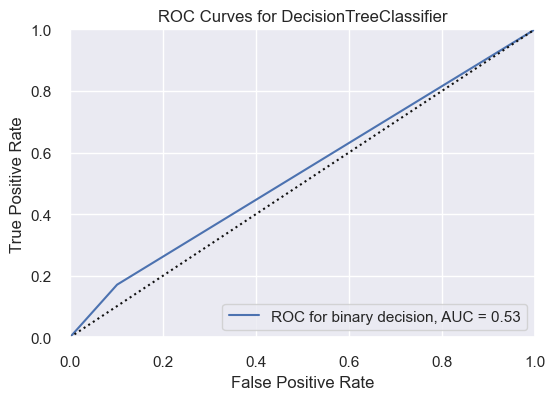

<Axes: title={'center': 'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [109]:
fig, ax = plt.subplots(figsize=(6, 4))

visualizer = ROCAUC(ada_, binary=True, 
                    random_state=1234)

visualizer.fit(X_ada, y_ada)         
visualizer.score(X_val, y_val)
visualizer.show() 

### Transformer NEARMISS 

Lorsqu’au contraire le nombre d’observations dans le dataset est assez important, on a la possibilité de sous-échantillonner les observations associées à la classe la plus prépondérante.
NearMiss vise à séparer les observations correspondantes à des classes différentes. Son principe est de supprimer les observations de la classe majoritaire lorsque des observations associées à des classes différentes sont proches l’une de l’autre.

In [77]:
 # Choix de la taille du nouveau dataset 
distribution_of_samples = {0:17110, 1:17000}
# Sous-Echantillonnage en utilisant la méthode NearMiss 
nmiss = NearMiss(sampling_strategy = distribution_of_samples)
X_near, y_near= nmiss.fit_resample(X_train,y_train)
print("y_near -Resampling NEARMISS")
print(pd.DataFrame({
    "COUNT": y_near.value_counts(),
    "RATIO": y_near.value_counts() / len(y_near) * 100}))
print('-----------------------------------------------')
# Entraînement du modèle d'arbre
nearmiss_=model1.fit(X_near, y_near)
# Affichage des résultats
y_pred = nearmiss_.predict(X_val)
print(classification_report_imbalanced(y_val, y_pred))


y_near -Resampling NEARMISS
   COUNT   RATIO
0  17110 50.1612
1  17000 49.8388
-----------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.31      0.74      0.46      0.48      0.22     84816
          1       0.09      0.74      0.31      0.15      0.48      0.24      7438

avg / total       0.86      0.34      0.70      0.44      0.48      0.22     92254



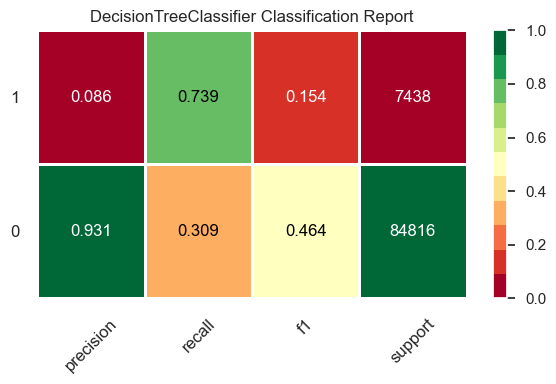

<Axes: title={'center': 'DecisionTreeClassifier Classification Report'}>

In [78]:
fig, ax = plt.subplots(figsize=(6, 4))

visualizer = ClassificationReport(nearmiss_, support=True, cmap='RdYlGn')

visualizer.fit(X_near, y_near)        # Fit the visualizer and the model
visualizer.score(X_val, y_val)        # Evaluate the model on the val data
visualizer.show()    

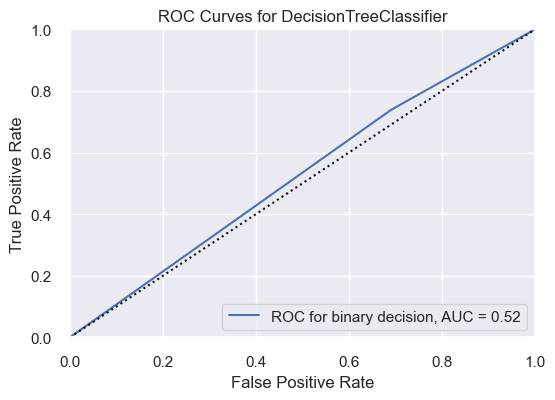

<Axes: title={'center': 'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [79]:
fig, ax = plt.subplots(figsize=(6, 4))

visualizer = ROCAUC(nearmiss_, binary=True, 
                    random_state=1234)

visualizer.fit(X_near, y_near)         
visualizer.score(X_val, y_val)
visualizer.show() 

In [36]:
# tableau récapitulatif
perfo_balanced_sampling

perfo_balanced_sampling=pd.DataFrame(
             { "Unnamed: 0": ['RandomOverSampler','SMOTE',
             'Bordeline SMOTE ', 'Bordeline SVMSMOTE',
             'ADASYN','RamdomUnderSAmpler','NEARMISS'],
             "ROC_AUC":[0.57,0.53,0.53,0.50,0.50,0.58,0.52],
             "F1_SCORE_classe1":[0.13,0.15,0.15,0.13,0.15,0.18,0.15]},
      index=[0,1,2,3,4,5,6]).rename(columns={"Unnamed: 0": "Modeles","ROC_AUC":"AUC"})


perfo_balanced_sampling

,Modeles,AUC,F1_SCORE_classe1
0,RandomOverSampler,0.5700,0.1300
1,SMOTE,0.5300,0.1500
2,Bordeline SMOTE,0.5300,0.1500
3,Bordeline SVMSMOTE,0.5000,0.1300
4,ADASYN,0.5000,0.1500
5,RamdomUnderSAmpler,0.5800,0.1800
6,NEARMISS,0.5200,0.1500


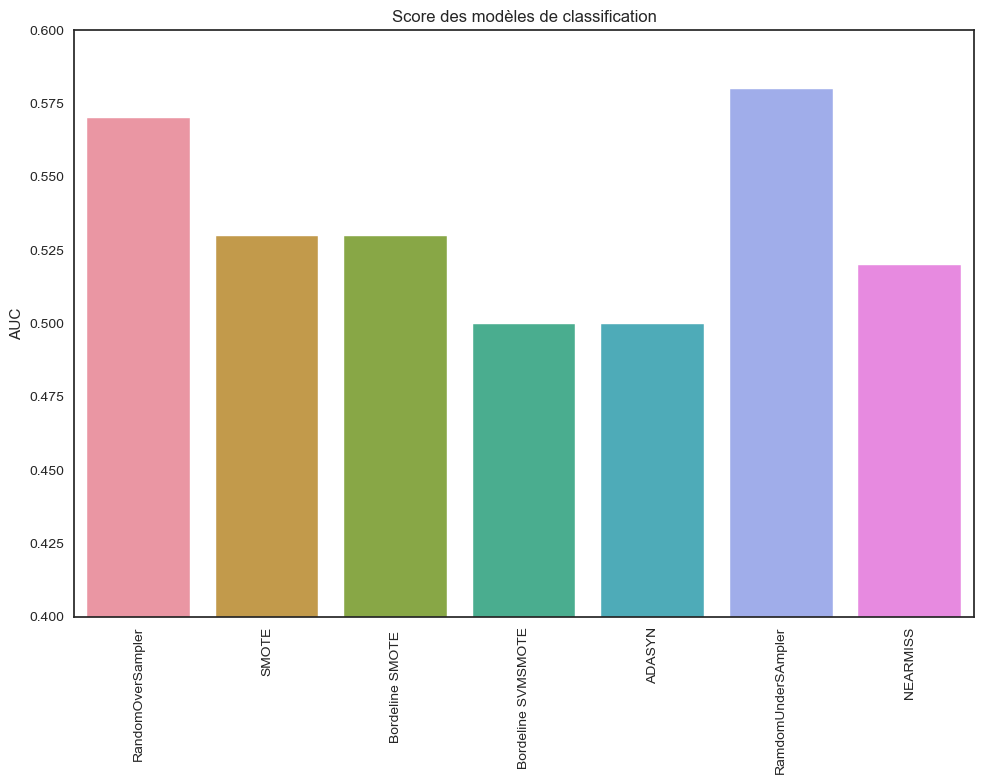

In [40]:
# graphique accuracy des modeles de classification supervisée
plt.figure(figsize=(10, 8))
sns.barplot(x = perfo_balanced_sampling['Modeles'],
            y = perfo_balanced_sampling['AUC'])
plt.title('Score des modèles de classification')
plt.xlabel('')
plt.ylabel('AUC')
plt.ylim(0.40,0.60)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('performance final.jpg')
plt.show()

##  Cost-Sensitive Learning

La classification pénalisée permet d’imposer un coût supplémentaire au modèle pour les erreurs de classification commises sur la classe minoritaire pendant l'entrainement.
Ces pénalités peuvent biaiser le modèle pour qu’il accorde plus d’attention à la classe minoritaire.  
Dans la plupart des classes d’algorithmes de scikit-learn, il est possible de simplement utiliser le paramètre `class_weight`. Il permet de pénaliser les erreurs faites sur une classe par un nouveau poids.  
Les poids doivent être indiqués sous forme de dictionnaire, par exemple : `{0:1, 1:5}`, pour donner 5 fois plus de poids aux erreurs faites sur la classe 1.   
L’argument ` »balanced »` permet d’associer à chaque classe un poids inversement proportionnel à sa fréquence.

Reprenons notre modèle d'arbre et appliquons lui un coût supplémentaire

In [80]:
model2=DecisionTreeClassifier(random_state=1234,class_weight={0:1, 1:10})


In [81]:
model2.fit(X_train,y_train)
ypred=model2.predict(X_val)
    
print(confusion_matrix(y_val,ypred))
print(classification_report(y_val,ypred))

[[78110  6706]
 [ 6455   983]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     84816
           1       0.13      0.13      0.13      7438

    accuracy                           0.86     92254
   macro avg       0.53      0.53      0.53     92254
weighted avg       0.86      0.86      0.86     92254



In [82]:
# Sous-échantillonnage
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)

print("y_ru -Resampling target")
print(pd.DataFrame({
    "COUNT": y_ru.value_counts(),
    "RATIO": y_ru.value_counts() / len(y_ru) * 100}))
print('-----------------------------------------------')
# Entraînement du modèle d'arbre
rd_under_bal_=model2.fit(X_ru, y_ru)
# Affichage des résultats
y_pred = rd_under_bal_.predict(X_val)
print(classification_report_imbalanced(y_val, y_pred))


y_ru -Resampling target
   COUNT   RATIO
0  17387 50.0000
1  17387 50.0000
-----------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.61      0.52      0.74      0.56      0.32     84816
          1       0.11      0.52      0.61      0.17      0.56      0.32      7438

avg / total       0.87      0.60      0.53      0.69      0.56      0.32     92254



In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

visualizer = ROCAUC(rd_under_bal_, binary=True, 
                    random_state=1234)

visualizer.fit(X_ru, y_ru)         
visualizer.score(X_val, y_val)
visualizer.show() 

Comparons avec le modèle de sous-échantillonnage vu ci-dessus

 Il n'y a pas dans ce cas précis d'amélioration du f-score après utilisation d'un coût supplémentaire.


Après avoir passé en revue 2 différentes façons de gérer les déséquilibres de classes , nous allons dans la 3eme partie passer à la modélisation

In [102]:
 # créer dataframe pour sauvegarde données normalisées

X_train_std = pd.DataFrame(X_train, columns=list(X_train_df))
X_val_std = pd.DataFrame(X_val, columns=list(X_val_df))
X_train_std.shape

(215257, 55)

In [103]:

# sauvegardes des jeux de données utilisés pour les modélisations
X_train_std.to_csv(r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P7\data\preproc\X_train_mod.csv',index=False)
X_val_std.to_csv(r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P7\data\preproc\X_val_mod.csv',index=False)
X_test.to_csv(r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P7\data\preproc\X_test_mod.csv',index=False)
y_train.to_csv(r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P7\data\preproc\y_train_mod.csv',index=False)
y_val.to_csv(r'C:\Users\serge\OneDrive\Documents\Documents\DATA SCIENTIST\P7\data\preproc\y_val_mod.csv',index=False)